# В этом юните мы попрактикуемся в решении задач кластеризации и используем полученные знания, чтобы оценить результаты.
Мы будем использовать данные, взятые с датчиков акселерометров и гироскопов смартфонов Samsung Galaxy S3. Телефоны носили в кармане добровольцы в возрасте от 19 до 49 лет. Смартфоны постоянно фиксировали значения ускорения и скорости по трём измерениям, а поведение людей записывали на видео, чтобы вручную отметить, какую физическую активность осуществлял человек в тот или иной момент.

Данные содержат следующие признаки:
- различные показатели с акселерометра и гироскопа;
- метка активности (физическая активность человека в конкретный момент).

Попробуем на основе данных с гироскопа и акселерометра разделить активности людей на некоторые схожие по своим характеристикам группы. В идеале наблюдения во время ходьбы должны попасть в один кластер, наблюдения во время подъёма по лестнице — в другой и т. д.

In [43]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [45]:
train = pd.read_table('data/train.txt', delim_whitespace=True, header=None)
test = pd.read_table('data/test.txt', delim_whitespace=True, header=None)
X = pd.concat([train, test], axis=0)
X.shape

(10299, 561)

In [76]:
y_train = pd.read_table('data/train_labels.txt', delim_whitespace=True, header=None)
y_test = pd.read_table('data/test_labels.txt', delim_whitespace=True, header=None)
y = pd.concat([y_train, y_test], axis=0)[0]
y.shape

(10299,)

In [77]:
y.value_counts()

0
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64

Как видите, есть ряд активностей, обозначенных цифрами. Эти метки означают следующее:
* 1 — ходьба;
* 2 — подъём;
* 3 — спуск;
* 4 — сидение;
* 5 — стояние;
* 6 — лежание.

In [48]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [51]:
round(X.iloc[0, 0], 2)

0.21

### Задание 4.4

Пора переходить к кластеризации. Для начала определите оптимальное количество кластеров, используя внутренние меры кластеризации. Используйте все известные вам коэффициенты, реализуемые в библиотеке sklearn: 
- коэффициент силуэта
- индекс Калински — Харабаса
- индекс Дэвиса — Болдина 

В качестве алгоритма возьмите k-means++, в качестве значения параметра random_state — число 42.

Выведите оптимальное количество кластеров для каждой метрики, перебирая значения от 2 до 9 включительно. Также введите значение каждой метрики, округлённое до двух знаков после точки-разделителя.

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [60]:
clusters = list(range(2, 10))

In [61]:
def get_score(scorer, X, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    model.fit(X)
    return scorer(X, model.labels_)

## Коэффициент силуэта

In [62]:
scores = []

for n_clusters in clusters:
    scores.append(get_score(silhouette_score, X, n_clusters))

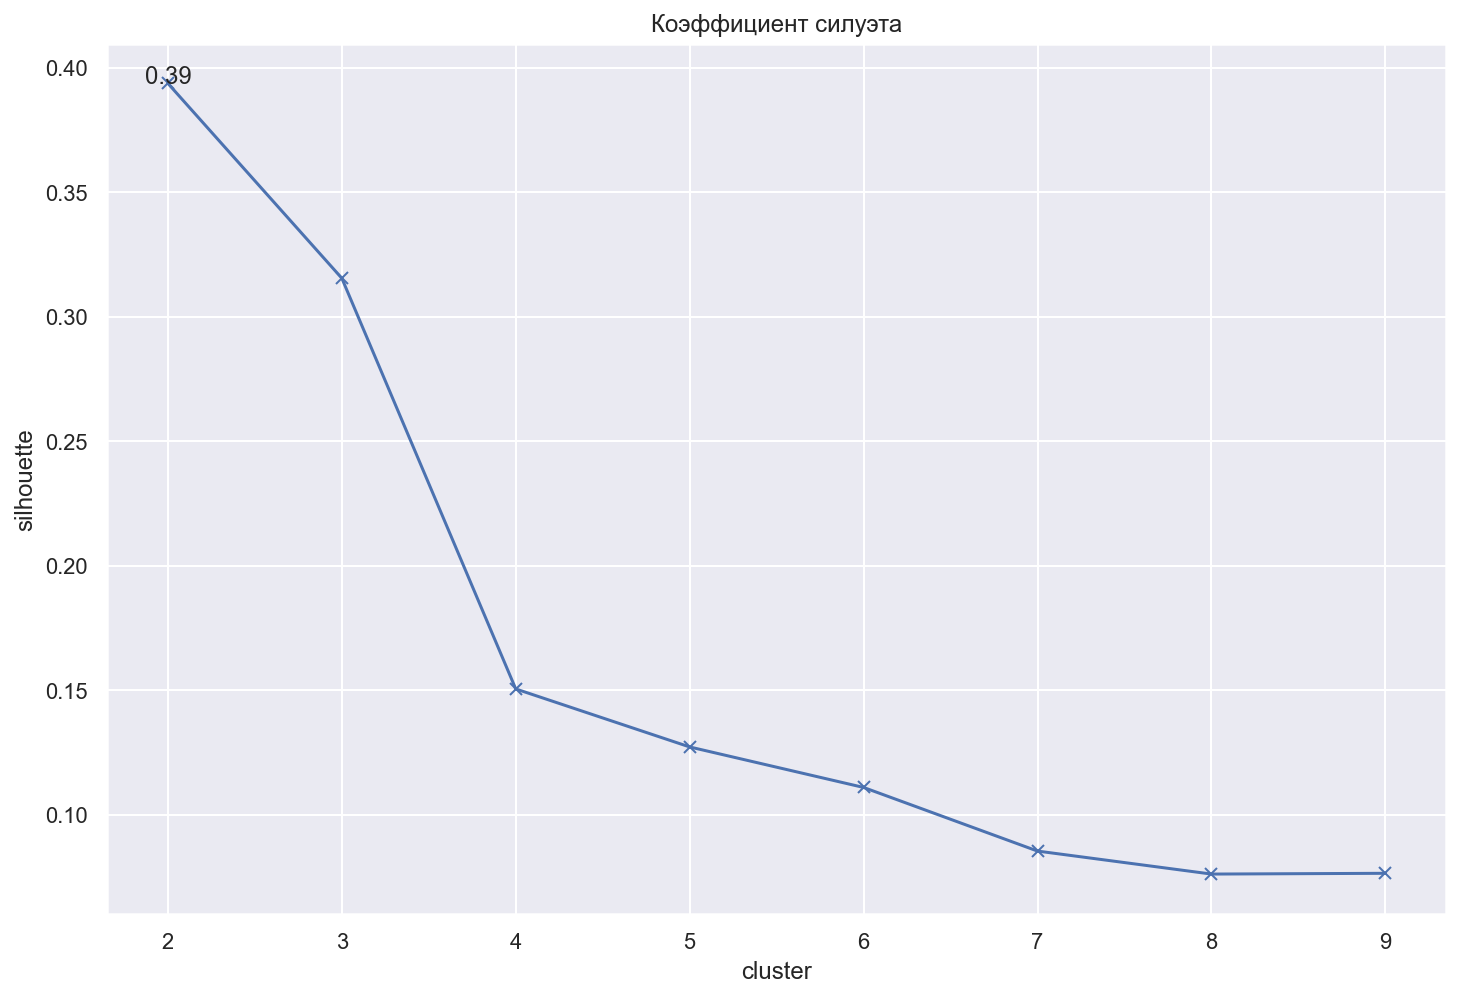

In [63]:
plt.xlabel('cluster', fontsize=12)
plt.ylabel('silhouette', fontsize=12)
plt.title('Коэффициент силуэта')
plt.plot(clusters, scores, 'xb-')

max_score_index = np.argmax(scores)
plt.text(clusters[max_score_index], 
         scores[max_score_index], 
         f'{scores[max_score_index]:.2f}', 
         ha='center')
plt.show()

## Индекс Калински-Харабаса

In [64]:
scores = []

for n_clusters in clusters:
    scores.append(get_score(calinski_harabasz_score, X, n_clusters))

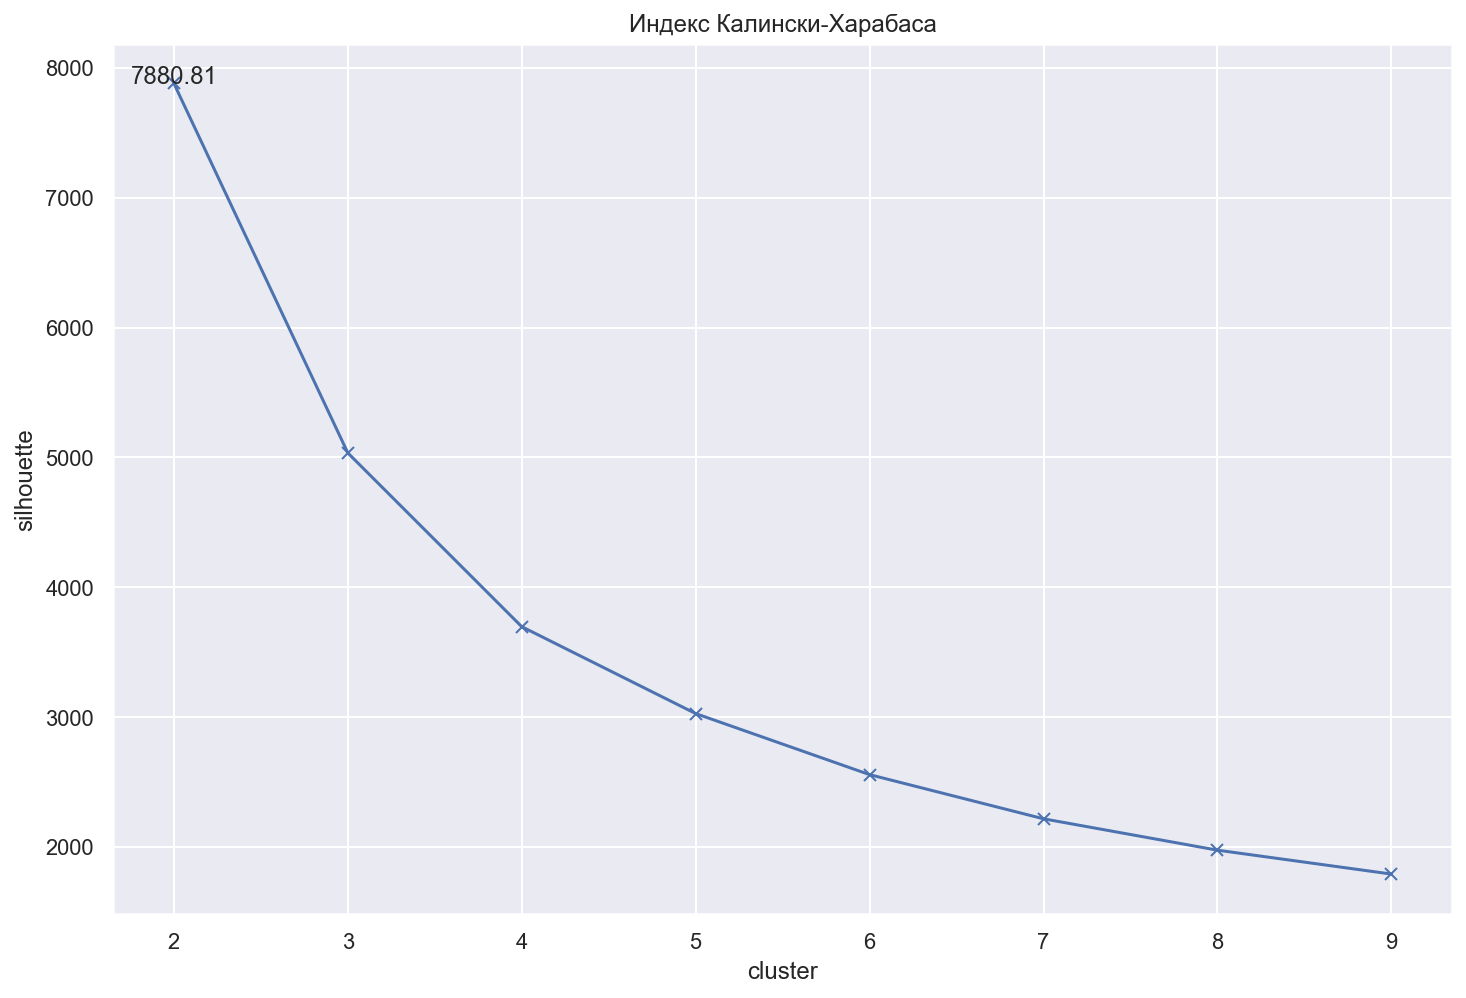

In [65]:
plt.xlabel('cluster', fontsize=12)
plt.ylabel('silhouette', fontsize=12)
plt.title('Индекс Калински-Харабаса')
plt.plot(clusters, scores, 'xb-')

max_score_index = np.argmax(scores)
plt.text(clusters[max_score_index],
         scores[max_score_index], 
         f'{scores[max_score_index]:.2f}', 
         ha='center')
plt.show()

## Индекс Дэвиса-Болдина

In [66]:
scores = []

for n_clusters in clusters:
    scores.append(get_score(davies_bouldin_score, X, n_clusters))

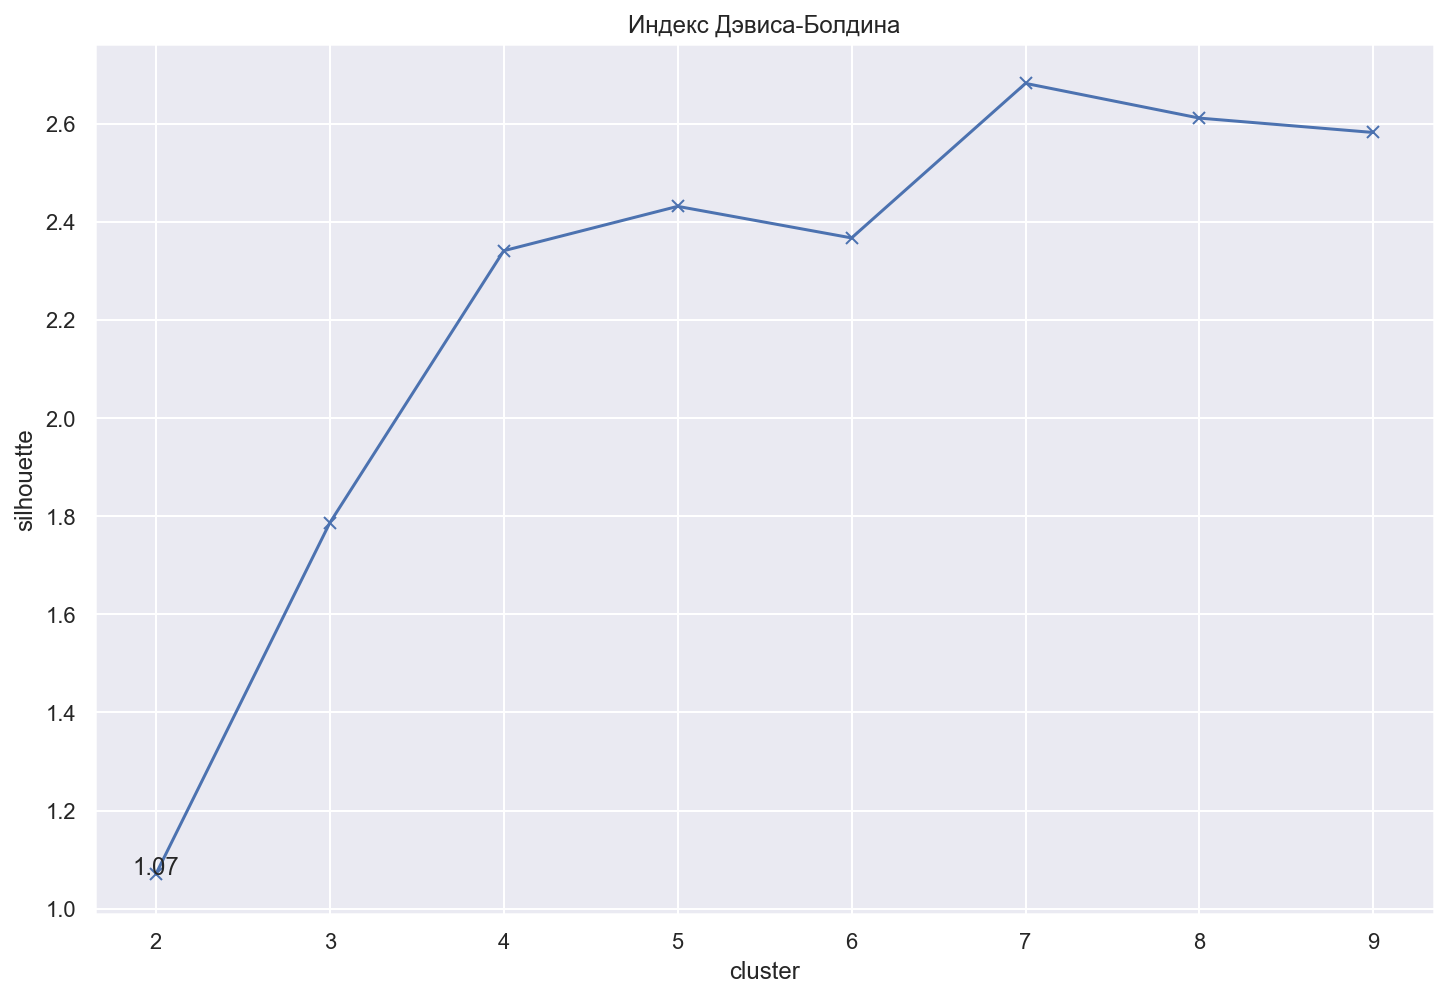

In [67]:
plt.xlabel('cluster', fontsize=12)
plt.ylabel('silhouette', fontsize=12)
plt.title('Индекс Дэвиса-Болдина')
plt.plot(clusters, scores, 'xb-')

min_score_index = np.argmin(scores)
plt.text(clusters[min_score_index], 
         scores[min_score_index], 
         f'{scores[min_score_index]:.2f}', 
         ha='center')
plt.show()

### Задание 4.5
Теперь давайте оценим качество кластеризации с точки зрения внешних мер. Реализуйте кластеризацию с помощью классической версии алгоритма k-means. Пусть количество кластеров будет соответствовать количеству активностей. Задайте следующие значения параметров: random_state=42, init='random'.

В качестве ответов введите значения получившихся мер, предварительно округлив их до двух знаков после точки-разделителя.

In [68]:
model = KMeans(n_clusters=6, init='random', random_state=42)
labels = model.fit_predict(X)

In [71]:
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score

In [79]:
print(f'Однородность: {homogeneity_score(y, labels):.2f}')
print(f'Полнота: {completeness_score(y, labels):.2f}')
print(f'ARI (скорректированный индекс Рэнда): {adjusted_rand_score(y, labels):.2f}')

Однородность: 0.54
Полнота: 0.58
ARI (скорректированный индекс Рэнда): 0.42


### Задание 4.6
Выясните, к каким кластерам были преимущественно отнесены различные активности (т. е. в какой кластер попало большинство наблюдений с этой активностью). Нумерацию кластеров начинайте с 1.

In [86]:
ct = pd.crosstab(y, labels)
ct.index = ['хотьба', 'подъём', 'спуск', 'сидение', 'стояние', 'лежание']
ct.columns = list(range(1, 7))
ct

,1,2,3,4,5,6
хотьба,0,0,903,78,741,0
подъём,0,0,1242,5,295,2
спуск,0,0,321,196,889,0
сидение,91,1238,1,0,0,447
стояние,0,1346,0,0,0,560
лежание,1556,54,5,0,0,329
